# Flujo Monofásico en 2D con Algoritmo de Thomas

**Objetivo general**
- El alumno resolverá la ecuación de Laplace en dos dimensiones, la cual representa el flujo monofásico incompresible en estado estable, con propiedades del fluido y del medio constantes. Mediante la solución de esta ecuación, se conocerán los tipos de condiciones de frontera y los tipos de solvers que se aplican en la solución de problemas relacionados con la Simulación Matemática de Yacimientos (SMY).

**Objetivos particulares**
- Conocer e identificar los tipos de condiciones a la frontera utilizadas en SMY.
- Identificar la dirección del flujo de fluidos de acuerdo a las isobaras.


**Trabajo realizado con el apoyo del Programa UNAM-DGAPA-PAPIME PE101922**
  
## Contenido
- [1 - Resolución de un problema de ingeniería mediante matemática computacional](#1)
- [2 - Condiciones de frontera](#2)
    - [2.1 - Primera clase (Neumann)](#2.1)
    - [2.2 - Segunda clase (Dirichlet)](#2.2)
    - [Ejercicio 1. ](#ej-1)
- [3 - Resolución del problema para flujo monofasico en 2D](#3)
    - [3.1 - Algoritmo de Thomas.](#3.1)
    - [Ejercicio 2](#ej-2)


<a name='1'></a>
## 1. Resolución de un problema de ingeniería mediante matemática computacional 
Se realiza la siguiente metodología:
1. Definir un modelo físico conceptual
2. Definir el modelo matemático
3. Definir el modelo numérico
4. Definir el modelo computacional (algoritmo de solución)

### 1.1 Modelo físico conceptual

Se inyecta un fluido a presión constante (**1,000 psi**) y se produce a presión constante (**500 psi**), en un medio poroso bidimensional homogéneo (de longitud Lx = **1,000 ft** y Ly = **500 ft** con permeabilidad y porosidad constantes), así mismo las propiedades del fluido no dependen de la presión, adicionalmente el medio poroso se encuentra saturado completamente de este fluido, por lo que se desea conocer el gradiente de presión en estado permanente.

1. No se consideran los efectos de la fuerza de gravedad
2. No hay fuentes ni sumideros
3. El fluido es incompresible y la viscosidad constante
4. El medio está inicialmente saturado del fluido
5. Ya se ha llegado al estado estable o permanente
6. Las permeabilidades en dirección $x$ y $y$ son iguales e invariantes en el espacio y tiempo 

Partiendo de la ecuacion general de balance de materia para flujo monofásico (de cualquier fluido $\alpha$) en medios porosos se tiene:

$$\frac{\partial \phi\rho_\alpha}{\partial t} - \nabla (\rho_\alpha \frac{k}{\mu}(\nabla\rho_\alpha - \rho_\alpha \delta\nabla z)) = q_\alpha$$

### 1.2 y 1.3 Modelo matemático y numérico
Tomando en cuenta las consideraciones del modelo físico se llega a:
$$\frac{\partial^2 \rho_\alpha}{\partial x^2} + \frac{\partial^2 \rho_\alpha}{\partial y^2} = 0$$

Discretizando la ecuacion anterior en una malla bidimensional se llega a:

$$AP_{i,j}p_i = AE_{i,j}p_{i+1, j}+ AW_{i,j}p_{i-1, j} + AN_{i,j}p_{i,j+1} + AS_{i,j}p_{i-1, j} + B_{i,j}$$

$$i = 1,2,3,4,...,nx-2$$
$$j = 1,2,3,4,...,ny-2$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import funciones_personalizadas as fp

from matplotlib import animation, cm
from IPython.display import HTML

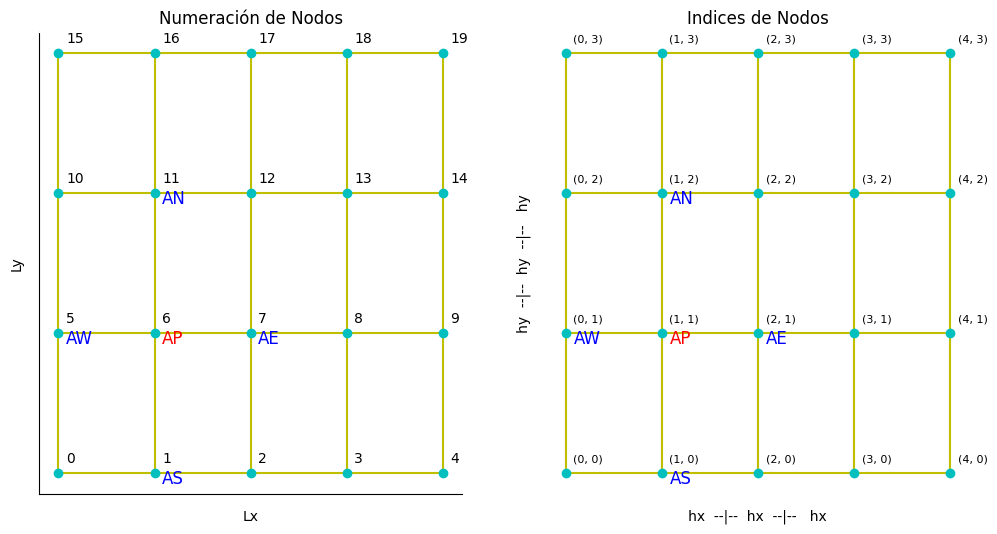

Nodo discretizado: 


(1, 1)

In [2]:
# Considere una malla rectangular de 1,000 ft x 500 ft, en el eje x e y, respectivamente. Con 5 nodos en x y 4 en y.

nodos_x, nodos_y = 5, 4
longitud_x, longitud_y = 1000, 500
nx_a_discretizar, ny_a_discretizar = 1,1

fp.discretizacion_en_malla_rectangular(longitud_x, longitud_y, nodos_y, nodos_x, nx_a_discretizar, ny_a_discretizar)

In [3]:
nodos_x, nodos_y = 5, 4
nodo_a_discretizar = 1

fp.generar_matriz(nodos_x, nodos_y, nodo_a_discretizar)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,AP,AE,0,0,0,AN,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,AW,AP,AE,0,0,0,AN,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,AW,AP,AE,0,0,0,AN,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,AW,AP,AE,0,0,0,AN,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,AW,AP,0,0,0,0,AN,0,0,0,0,0,0,0,0,0,0
5,AS,0,0,0,0,AP,AE,0,0,0,AN,0,0,0,0,0,0,0,0,0
6,0,AS,0,0,0,AW,AP,AE,0,0,0,AN,0,0,0,0,0,0,0,0
7,0,0,AS,0,0,0,AW,AP,AE,0,0,0,AN,0,0,0,0,0,0,0
8,0,0,0,AS,0,0,0,AW,AP,AE,0,0,0,AN,0,0,0,0,0,0
9,0,0,0,0,AS,0,0,0,AW,AP,0,0,0,0,AN,0,0,0,0,0


### Discretización de las ecuaciones

Aplicando diferencias finitas centradas

$$\frac{\partial^2 \rho_\alpha}{\partial x^2}+ \frac{\partial^2\rho_\alpha}{\partial y^2} =
\frac{P_{i+1,j-1} - 2P_{i,j} + P_{i-1,j}}{hx^2}
+ \frac{P_{i,j+1} - 2P_{i,j} + P_{i,j-1}}{hy^2} = 0$$

Despejando $P_{i,j}$ (donde P es el valor incognita)

$$P_{i,j}(\frac{2}{hx^2} + \frac{2}{hy^2})  
= \frac{P_{i+1,j}}{hx^2} + \frac{P_{i-1,j}}{hx^2} + \frac{P_{i,j+1}}{hy^2} + \frac{P_{i,j-1}}{hy^2}
$$

La ecuación anterior se puede reescribir como:
$$AP P_{i,j} = AE P_{i+1,j} + AW P_{i-1,j} + AN P_{i,j+1}
+ AS P_{i,j-1} + B_{i,j}$$

$Donde:$

$AP = (\frac{2}{hx^2} + \frac{2}{hy^2})$,
$AE = \frac{1}{hx^2}$,
$AW = \frac{1}{hx^2}$,
$AN = \frac{1}{hy^2}$,
$AS = \frac{1}{hy^2}$,

In [4]:
def ecuaciones_discretizadas(lx, ly, nx, ny, hx, hy):
    """
    Esta funcion genera los coeficientes de la ecuacion de flujo monofasico discretizada. No se consideran las
    condiciones de frontera.
    Parametros
    ----------
    lx, ly : entero o flotante.
        Longitud en el eje x e y.
    nx, ny : int, int.
        Nodos en de la malla rectangular.
    Retorna
    -------
    AP,AE,AW,AN,AS,B : ndarray. 
        Arreglos en 2D para generar una matriz pentadiagonal.
    """
    
    # se definen los arreglos en dos dimensiones
    AP = np.zeros((nx,ny)) 
    AE = np.zeros((nx,ny))
    AW = np.zeros((nx,ny))
    AN = np.zeros((nx,ny))
    AS = np.zeros((nx,ny))
    B = np.zeros((nx,ny))
    
    for j in range (1,ny-1):
        for i in range (1,nx-1):
            AP[i][j]=2.0/hx**2.0+2.0/hy**2.0
            AE[i][j]=1.0/hx**2.0
            AW[i][j]=1.0/hx**2.0
            AN[i][j]=1.0/hy**2.0
            AS[i][j]=1.0/hy**2.0
            B[i][j]=0.0

    return AP,AE,AW,AN,AS,B

<a name='2'></a>
## 2. Codiciones de frontera
De acuerdo con la SEG Wiki, las condiciones de frontera se aplican en el término integral superficial de la ecuación integral de un campo y consiste en valores prescritos de la solución y de las derivadas de la solución en la frontera. Cuando los valores de campo se especifican las condiciones se denominan **condiciones de Dirichlet**. Cuando se especifican las derivadas las condiciones se llaman **condiciones de Neumann**.

<a name='2.1'></a>
### 2.1 Primera clase o Dirichlet
Esta condición indica una funcion conocida que varia en el tiempo o un escalar dado (invariante en el tiempo) en las fronteras, es decir:

$$p_1=f(t,y) \quad o \quad p1=cte_1 = 1,000 psi$$
$$p_2=f(t,x) \quad o \quad p1=cte_2 = 500 psi$$
$$p_3=f(t,y) \quad o \quad p1=cte_3 = 500 psi$$
$$p_4=f(t,x) \quad o \quad p1=cte_4 = 500 psi$$

**Implementación:**
1. Identificar las fronteras y los puntos de la ecuacion discreta donde se implementará la condición
2. Llevar a cabo las sustituciones pertinenters en cada ecuación discreta, para este caso:

$$AP_{i,j}P_i = AE P_{i+1,j} + AW P_{i-1,j} + AN P_{i,j+1}
+ AS P_{i,j-1} + B_{i,j}$$

Considerando una malla con **nx = 5x** y **ny = 4**, se tiene la siguiente figura:
<img src="./utils/figs/fronteras.png" width="500px">

#### Para la frontera SUR:
Tomando en cuenta la figura anterior, se puede apreciar que no existe relacion con la presión $Sur (i,j-1)$, por lo tanto, la ecuación se reduce a:

$$AP_{i,j}p_{i} = AE P_{i+1,j} + AW P_{i-1,j} + AN P_{i,j+1}
+ B_{i,j}$$

En este caso el valor de presión está definido, por lo que el sistema de ecuaciones de reduce a:

$$AP_{i,j}P_i = B_i$$

$$para \quad i=0,1,2,3,4 \quad j=0$$
$$donde \quad AP_{i,j}=1 \quad y \quad B_{i,j}=Cte_2$$

*Todos los demás coeficientes se asignan a cero*

Para el resto de las fronteras se utiliza la misma lógica


In [5]:
def condiciones_de_frontera_dirichlet(P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nx, ny):
    """
    Esta función modifica los coeficientes y asigna las condiciones de frotera de primera clase. 
    """
    for i in range (1,nx-1):
        AP[i][0]=1.0
        AW[i][0]=0.0    
        AE[i][0]=0.0      #Frontera sur
        AN[i][0]=0.0
        B[i][0]=P2
            
        AP[i][ny-1]=1.0
        AW[i][ny-1]=0.0    
        AE[i][ny-1]=0.0    #Frontera norte
        AS[i][ny-1]=0.0
        B[i][ny-1]=P4

    for j in range (0,ny):
        AP[0][j]=1.0
        AE[0][j]=0.0      #Frontera Oeste
        AN[0][j]=0.0
        AS[0][j]=0.0
        B[0][j]=P1
        
        AP[nx-1][j]=1.0
        AW[nx-1][j]=0.0
        AN[nx-1][j]=0.0   #Frontera Este
        AS[nx-1][j]=0.0
        B[nx-1][j]=P3

<a name='2.2'></a>
### 2.2 Fronteras de segunda clase Neumann (No flujo o frontera cerrada)
Éstas especifican la derivada normal a la frontera para ser cero o constante.

$$p_1=f(t,y) \quad o \quad p1=cte_1 = 1,000 psi$$

$$ \frac{dp}{dy}\big|_{ 2} = f(t,x) \quad o \quad \frac{dp}{dy}\big|_{ 2} = 0.0$$

$$p_3=f(t,y) \quad o \quad p1=cte_3 = 500 psi$$

$$ \frac{dp}{dy}\big|_{ 4} = f(t,x) \quad o \quad \frac{dp}{dy}\big|_{ 4} = 0.0$$

Discretización:

**Frontera Sur:**
$$\frac{dp}{dy}\big|_{ 2} = 0.0$$

Sustituyendo una diferencia adelantada:
$$\frac{P_{i,j+1}-P_{i,j}}{hy} = 0$$

$$P_{i,j+1} = P_{i,j}$$


**Frontera Norte:**
$$\frac{dp}{dy}\big|_{ 2} = 0.0$$

Sustituyendo una diferencia atrasada:
$$\frac{P_{i,j}-P_{i,j-1}}{hy} = 0$$

$$P_{i,j} = P_{i,j-1}$$

In [6]:
def condiciones_de_frontera_neumann(x, P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nx, ny):
    """
    Esta función modifica los coeficientes de la matriz y asigna las condiciones de frontera de segunda clase. 
    """
    
    for i in range (1, nx-1):
        AP[i][0]=1.0
        AW[i][0]=0.0    
        AE[i][0]=0.0      #Frontera sur
        AN[i][0]=1.0
        B[i][0]=0
        
        AP[i][ny-1]=1.0
        AW[i][ny-1]=0.0    
        AE[i][ny-1]=0.0    #Frontera norte
        AS[i][ny-1]=1.0
        B[i][ny-1]=0.0
    
    for j in range (0,ny):
        AP[0][j]=1.0
        AE[0][j]=0.0      #Frontera Oeste
        AN[0][j]=0.0
        AS[0][j]=0.0
        B[0][j]=P1
        
        AP[nx-1][j]=1.0
        AW[nx-1][j]=0.0
        AN[nx-1][j]=0.0   #Frontera Este
        AS[nx-1][j]=0.0
        B[nx-1][j]=P3

<a name='3'></a>
## 3. Resolución del problema para flujo monofásico en 2D

Los pasos para resolver el problema de flujo monofásico en 2D se presentan en el siguiente algoritmo:
- Definir las variables del problema (nodos, longitudes, etc)
- Implementar las ecuaciones discretizadas
- Aplicar las condiciones de frontera
- **Resolver la matriz con algún solver**

A continuación se mostraran una comparativa entre el algortimo de Thomas y las alternativas de SciPy.  

<a name='3.1'></a>
### 3.1 Solución mediante el Algortimo de Thomas

In [7]:
# variables del problema
nx, ny = 10, 10
lx, ly = 500, 500

#Generación de malla para graficar
x = np.linspace(0, lx, nx)
y = np.linspace(0, ly, ny)
malla_x, malla_y = np.meshgrid(x, y)

In [8]:
def flujo_monofasico_2d_thomas(i):
    """
    Esta funcion aplica el algoritmo de Thomas para resolver el problema de flujo monofasico en 2D.
    """
    
    """
        |---P4(NORTE)---|
        |               |
    P1(OESTE)        P3(ESTE)
        |               |
        |----P2(SUR)----|
    
    donde P es presión (psi)
    """
    P1 = 700+(i*10)
    P2, P3, P4  = 500.0, 500.0, 500.0
    Press = np.zeros((nx,ny))

    # se calcula el espaciamiento entre nodos
    hx = lx/(nx-1)
    hy = ly/(ny-1)
    
    # Llamar a la función para obtener los coeficientes
    AP, AW, AE, AN, AS, B = ecuaciones_discretizadas(lx, ly, nx, ny, hx, hy)
    
    """
    Ejercicio 1 y Ejercicio 2
    
    Modificar -----.
                   v
    """
    #Aplicar condiciones de frontera
    condiciones_de_frontera_dirichlet(P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nx, ny)
    
    # Resolver mediante Thomas
    iteramax, eps = 3000, 1.0E-04
    fp.algoritmo_thomas_2D(nx, ny, AP, AE, AW, AN, AS, B, Press, iteramax, eps)
    
    u = np.zeros((nx,ny)) 
    v = np.zeros((nx,ny)) 
    
    for j in range (1,ny-1):
        for i in range (1,nx-1):
            u[i][j]=-(Press[i+1][j]-Press[i-1][j])/(2*hx)  #Discretizamos por DFC de primer orden
            v[i][j]=-(Press[i][j+1]-Press[i][j-1])/(2*hy)
    
    return Press,u,v

In [9]:
Press,u,v  = flujo_monofasico_2d_thomas(1)

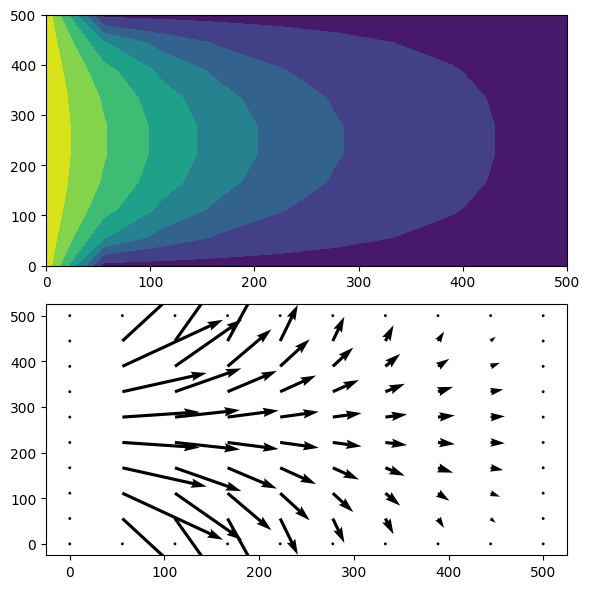

In [10]:
fig, ax = plt.subplots(2,1, figsize=(6,6))

ax[0].contourf(malla_x, malla_y, Press.T, cmap='viridis')
ax[1].quiver(malla_x, malla_y, u.T,v.T)

plt.tight_layout()
plt.show()

## Ejercicio 1 - uso de condiciones de frontera tipo Neumann

En el script **flujo_monofasico_2d_thomas(i)**:

    1.- Asigna 1,000 psi a la variable P3 y el resto de presiones en 500 psi

    2.- Sustituye la función que ejecuta las condiciones de frontera de primera clase (Dirichlet) e implementa las condiciones de segunda clase (Neumann). => condiciones_de_frontera_neumann(x, P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nx, ny)

    3.- Ejecuta las celdas de codigo modificadas y visualiza los resultados


---------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------

## Ejercicio 2 - condiciones de frontera mixtas (Neumann + Dirichlet)

En el script **condiciones_de_frontera_mixtas(x, P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nx, ny)** (se ubica al final del ejercicio):

    1.- Copia el contenido de la función => condiciones_de_frontera_neumann(x, P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nx, ny)

    2.- En la frontera Norte asigna el codigo que aplica las condiciones de primera clase (Dirichlet)

En el script **flujo_monofasico_2d_thomas(lx, ly, nx, ny)**:

    3.- Sustituye la función condiciones_de_frontera_neumann(x, P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nx, ny) por => condiciones_de_frontera_mixtas(x, P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nx, ny)
    
    4.- Modifica los nodos de la malla a 40 en nx y 40 en ny

    4.- Ejecuta las celdas de codigo modificadas y visualiza los resultados

### Notas:
En el ejericio 2, al aumentar a 40 el numero de nodos de la malla, el tiempo de computo aumenta significativamente. Para disminuir este tiempo se propone el uso de SciPy...